# Timeseries Survival Analysis Tutorial

This notebook aims to demonstrate how to perform survival analysis in the context of PV assets.

In [121]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

# Load in data

We read in the data below, where each column reflects data from an O&M (operation and maintenance) ticket. Note the following column descriptions:
- `randid` is an integer identifying the PV site
- `COD` identifies the commissioning date of the site
- `EventStart` is the recorded time of the event
- `Asset` identifies the asset involved in the event

In [167]:
om_df = pd.read_csv('example_data/example_om_survival_analysis_data.csv')
om_df.head(5)

,randid,COD,EventStart,Asset
0,0,2015-09-24,2016-05-18 09:00:00,Other
1,1,2014-08-01,2016-06-13 09:00:00,Other
2,2,2011-12-27,2016-11-10 09:00:00,Other
3,3,2015-07-22,2016-11-10 09:00:00,Other
4,4,2015-08-13,2016-11-24 09:00:00,Other


Later, we will estimate the failure of probability of each asset, so we can identify all of the unique assets below:

In [168]:
assets = om_df['Asset'].unique()
assets

array(['Other', 'Transformer', 'Inverter', 'Tracker', 'Facility',
       'Combiner'], dtype=object)

# Data Processing

Without knowing more about the nature of the observed events and how they may impact other systems at the sites, it is best to only consider the first failure for each site. Therefore, we will extract only the first record for each site.

In [171]:
first_fails_df = om_df.groupby('randid').first()
first_fails_df['time_to_failure_days'] = (pd.to_datetime(om_df['EventStart'])
                                          - pd.to_datetime(om_df['COD'])
                                          ).dt.days

However, we can still glean information from the other assets at each site. We can consider these assets as having a _right-censored_ first failure, which means that we stopped making observations before that asset experienced a failure. The amount of time elapsed since commissioning is still useful, as it tells us that the asset lasted without incident for _at least_ that long.

In [175]:
# construct new DataFrame
all_assets_df = pd.DataFrame(columns=first_fails_df.columns)

# repeat each row of first_fails_df for each unique asset
for asset in assets:
    df_to_append = first_fails_df.copy()
    df_to_append.Asset = asset
    all_assets_df = pd.concat((all_assets_df, df_to_append))

##### indicate whether the event was observed or censored #####
all_assets_df['was_observed'] = False
# loop through all sites
for randid in first_fails_df.index:
    # pull out the asset that failed first for this site
    observed_asset = first_fails_df.loc[randid, 'Asset']
    # create a mask identifying the rows matching the site of interest and asset that failed
    rows_to_index = np.bitwise_and(all_assets_df.index == randid, all_assets_df.Asset == observed_asset)
    # indicate this row was observed
    all_assets_df.loc[rows_to_index, 'was_observed'] = True

# Probability estimation

## Kaplan-Meier estimator

### Computation

Now, we are ready to estimate the probability of failure over time for each asset using the Kaplan-Meier estimator of the survival function. `scikit-survival` has an implementation of the estimator: `kaplan_meier_estimator(event, time_exit)`, where
- `event` denotes whether each event was observed
- `time_exit` denotes the time observed until each observation exited the study, either by a failure or via censoring

By including the optional keyword argument `conf_type='log-log'`, we can also obtain an estimate of the 95% confidence interval of the Kaplan-Meier estimator.

Note the Kaplan-Meier estimator is for the survival function. By subtracting it from 1, we get the probability of the first failure of the asset having occured by a point in time.

In [178]:
kaplan_meier_results = {}
for asset in assets:
    asset_df = all_assets_df[all_assets_df['Asset'] == asset]
    times, surv_func, conf_int = kaplan_meier_estimator(asset_df['was_observed'],
                                                        asset_df['time_to_failure_days'],
                                                        conf_type='log-log')
    kaplan_meier_results[asset] = {'times' : times,
                                   'fail_prob' : 100 * (1 - surv_func),
                                   'upper' : 100 * (1 - conf_int[0]),
                                   'lower' : 100 * (1 - conf_int[1])}

### Plotting

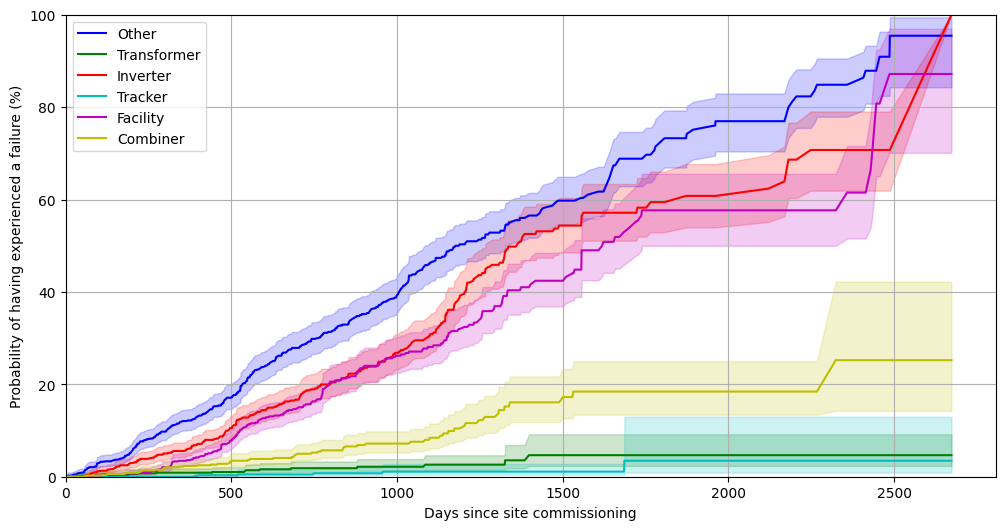

In [ ]:
plt.figure(figsize=(12,6))
colors = plt.cm.colors.BASE_COLORS.values()

for asset, color in zip(assets, colors):
    result = kaplan_meier_results[asset]
    plt.plot(result['times'], result['fail_prob'], color=color, label=asset)
    plt.fill_between(result['times'], result['lower'], result['upper'], color=color, alpha=0.2)

plt.legend();
plt.grid();
plt.xlim(0,None);
plt.ylim(0,100);
plt.xlabel('Days since site commissioning')
plt.ylabel('Probability of having experienced a failure (%)');